**Classifier Techniques**


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:00:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 91
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 4
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.073920
[LightGBM] [Info] Start training from score -1.123930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

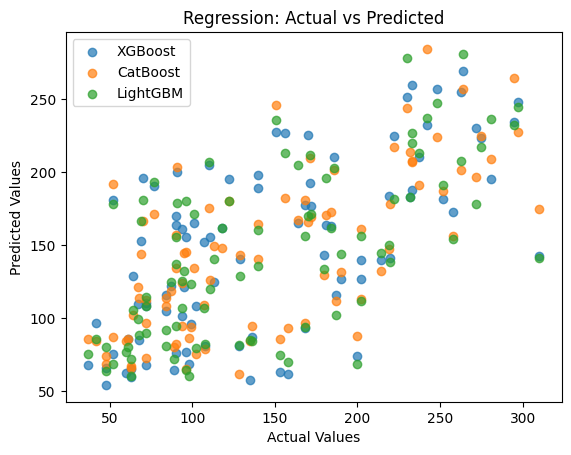

Regression Results:
XGBoost: {'MSE': 3351.001637862091}
CatBoost: {'MSE': 2760.549952405341}
LightGBM: {'MSE': 3203.0860673543248}


In [10]:
# Install necessary libraries
!pip install xgboost catboost lightgbm scikit-learn

# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, ndcg_score
from sklearn.datasets import load_iris, load_diabetes
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
import xgboost as xgb

# Seed for reproducibility
np.random.seed(42)

# Helper function for classification metrics
def classification_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    return {"Accuracy": acc, "Precision": precision, "Recall": recall}

# Helper function for regression metrics
def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {"MSE": mse}

# SECTION 1: Classifier Techniques
print("**Classifier Techniques**")
# Load Iris dataset for classification
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifiers = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "CatBoost": CatBoostClassifier(verbose=0),
    "LightGBM": LGBMClassifier()
}

classification_results = {}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    classification_results[name] = classification_metrics(y_test, y_pred)

# Display classification results
print("Classification Results:")
for model, metrics in classification_results.items():
    print(f"{model}: {metrics}")

# SECTION 2: Regression Techniques
print("\n**Regression Techniques**")
# Load Diabetes dataset for regression
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressors = {
    "XGBoost": XGBRegressor(),
    "CatBoost": CatBoostRegressor(verbose=0),
    "LightGBM": LGBMRegressor()
}

regression_results = {}

for name, reg in regressors.items():
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    regression_results[name] = regression_metrics(y_test, y_pred)
    # Plot actual vs predicted
    plt.scatter(y_test, y_pred, alpha=0.7, label=name)

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Regression: Actual vs Predicted")
plt.legend()
plt.show()

# Display regression results
print("Regression Results:")
for model, metrics in regression_results.items():
    print(f"{model}: {metrics}")


In [19]:
# Import necessary libraries
import numpy as np
import pandas as pd
import xgboost as xgb
from catboost import CatBoostRanker
from lightgbm import LGBMRanker
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score

print("\n**Ranking Techniques**")

# Generate a consistent ranking dataset
num_samples = 50  # Total number of samples
num_features = 2  # Number of features for ranking dataset

# Create a dataset with groups and relevance scores
ranking_data = pd.DataFrame({
    "query_id": np.repeat(np.arange(num_samples // 5), 5),  # 10 groups of 5 samples each
    "feature_1": np.random.randn(num_samples),
    "feature_2": np.random.randn(num_samples),
    "relevance": np.random.randint(0, 5, num_samples)  # Relevance scores: 0 to 4
})

# Features and labels
X = ranking_data[["feature_1", "feature_2"]]  # Features only
y = ranking_data["relevance"]
query_id = ranking_data["query_id"]

# Split dataset into train and test, ensuring alignment of groups
X_train, X_test, y_train, y_test, qid_train, qid_test = train_test_split(
    X, y, query_id, test_size=0.2, random_state=42
)

# Prepare group sizes for LightGBM and XGBoost
group_train = qid_train.value_counts(sort=False).sort_index().values
group_test = qid_test.value_counts(sort=False).sort_index().values

# Prepare DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
dtrain.set_group(group_train)
dtest.set_group(group_test)

# Define ranking models
ranking_models = {
    "XGBoost": xgb.train(
        {"objective": "rank:pairwise", "eval_metric": "ndcg"}, dtrain, num_boost_round=100
    ),
    "CatBoost": CatBoostRanker(loss_function="YetiRankPairwise", iterations=100, verbose=0),
    "LightGBM": LGBMRanker(objective="lambdarank", num_leaves=31, n_estimators=100),
}

# Train and predict with each model
ranking_results = {}

# XGBoost
y_pred_xgb = ranking_models["XGBoost"].predict(dtest)
ranking_results["XGBoost"] = ndcg_score([y_test], [y_pred_xgb])

# Prepare sorted data for CatBoost
catboost_data = pd.DataFrame(X_train).copy()
catboost_data["query_id"] = qid_train.values
catboost_data["relevance"] = y_train.values
catboost_data = catboost_data.sort_values(by="query_id")  # Sort by query_id for CatBoost

X_train_catboost = catboost_data.drop(columns=["query_id", "relevance"])
y_train_catboost = catboost_data["relevance"]
group_train_catboost = catboost_data["query_id"]

# CatBoost
ranking_models["CatBoost"].fit(
    X_train_catboost,
    y_train_catboost,
    group_id=group_train_catboost
)
y_pred_catboost = ranking_models["CatBoost"].predict(X_test)
ranking_results["CatBoost"] = ndcg_score([y_test], [y_pred_catboost])

# LightGBM
ranking_models["LightGBM"].fit(
    X_train,
    y_train,
    group=group_train
)
y_pred_lightgbm = ranking_models["LightGBM"].predict(X_test)
ranking_results["LightGBM"] = ndcg_score([y_test], [y_pred_lightgbm])

# Display ranking results
print("Ranking Results (NDCG Score):")
for model, score in ranking_results.items():
    print(f"{model}: {score:.4f}")



**Ranking Techniques**
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15
[LightGBM] [Info] Number of data points in the train set: 40, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet 